# NSU, vaje 1: osnove strojnega učenja v Pythonu

In [74]:
import numpy as np
import pandas as pd
import openml as oml

### A: obdelava podatkov
A.1: Naložite podatke iz CSV datoteke s paketom **pandas**. 

In [75]:
podatki = pd.read_csv('podatki.csv', index_col=0)

A.2: Osnovne informacij o podatkih. Izpišite prvih nekaj vrstic podatkov in si jih oglejte, nato pa izpišite še:
- število vrstic in stolpcev
- vrsto spremenljivke v vsakem stolpcu (v pomoč je funkcija **dtypes**), 
- povzetek statistike (pandas nam pomaga z **describe**), 
- število manjkajočih vrednosti v vsakem stolpcu (koristna je funkcija **isnull**).

In [76]:
podatki.head(5)

,X1,X2,X3,X4,X5,X6,Y
1,0.452553,69.113756,-2.558555,car,23.210163,NaN,1
2,0.865373,39.855286,-0.727901,bike,24.136736,NaN,0
3,NaN,82.321769,-6.092819,bike,70.441331,937875.790987164,0
4,0.568116,82.638111,-8.248877,car,NaN,197308.828588575,1
5,0.936621,34.460152,-9.577684,NaN,46.773121,253860.316937789,0


In [77]:
print('Stevilo vrstic in stolpcev: ', podatki.shape)
print('\nTipi podatkov:\n', podatki.dtypes)
print('\nPovzetek podatkov:\n', podatki.describe())
manjkajoce = podatki.isnull().sum()
print('\nStevilo manjkajocih vrednosti:\n', manjkajoce)

Stevilo vrstic in stolpcev:  (500, 7)

Tipi podatkov:
 X1    float64
X2    float64
X3    float64
X4     object
X5    float64
X6     object
Y       int64
dtype: object

Povzetek podatkov:
                X1          X2          X3          X5           Y
count  417.000000  425.000000  401.000000  418.000000  500.000000
mean     0.480240   49.712517   -0.326907   50.498433    0.376000
std      0.284564   28.518534    5.705867   29.939186    0.484865
min      0.002002    0.185484   -9.974356    0.048450    0.000000
25%      0.241174   25.220756   -5.220926   24.334954    0.000000
50%      0.466964   50.124783   -0.611887   49.792287    0.000000
75%      0.722863   74.834014    4.451901   78.042819    1.000000
max      0.999430   99.852905    9.928626   99.584908    1.000000

Stevilo manjkajocih vrednosti:
 X1     83
X2     75
X3     99
X4     91
X5     82
X6    134
Y       0
dtype: int64


A.3: Očistite podatke tako, da odpravite manjkajoče vrednosti. Na stolpcih, v katerih manjka manj kot petina vrednosti, izvedete imputacijo manjkajočih vrednosti s povprečjem oziroma najpogostejšo vrednostjo. Stolpce, v katerih manjka več kot petina vrednosti, odstranite.

In [78]:
def imputiraj(tabela, stolpec):
    if tabela[stolpec].dtype == 'float64':
        tabela[stolpec].fillna(tabela[stolpec].mean(), inplace=True)
    else:
        tabela[stolpec].fillna(tabela[stolpec].mode()[0], inplace=True)

def odstrani(tabela, stolpec):
    tabela.drop(stolpec, axis=1, inplace=True)
    
for stolpec in podatki.columns:
    if manjkajoce[stolpec] == 0:
        continue

    if podatki[stolpec].isnull().sum() < len(podatki[stolpec]) * 0.2:
        imputiraj(podatki, stolpec)
    else:
        odstrani(podatki, stolpec)

print(podatki.isnull().sum())

X1    0
X2    0
X3    0
X4    0
X5    0
Y     0
dtype: int64


A.4: Narišite grafe, ki vam bodo pomagali razumeti značilnosti podatkov:
- histogrami značilk in ciljne spremenljivke (pandas nudi **hist**)
- korelacijska matrika (pandas nudi tudi **corr**)

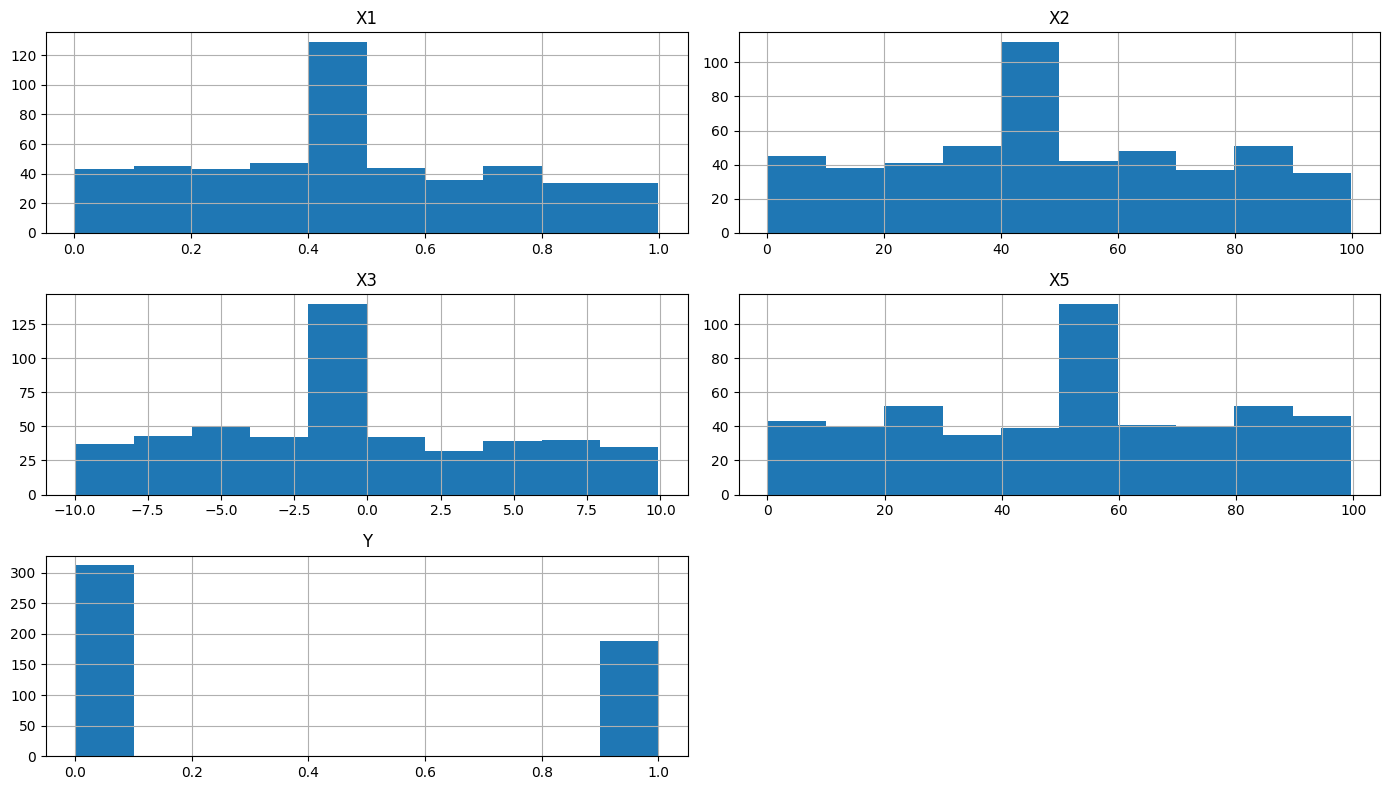

/tmp/ipykernel_11243/1767488823.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = podatki.corr()
/tmp/ipykernel_11243/1767488823.py:8: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,X1,X2,X3,X5,Y
X1,1.00,-0.02,0.01,0.02,-0.01
X2,-0.02,1.00,-0.05,0.05,-0.20
X3,0.01,-0.05,1.00,0.03,-0.05
X5,0.02,0.05,0.03,1.00,-0.03
Y,-0.01,-0.20,-0.05,-0.03,1.00


In [79]:
from matplotlib import pyplot

podatki.hist(figsize=(14,8))
pyplot.tight_layout()
pyplot.show()

corr = podatki.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

A.5: V nadaljevanju bomo za strojno učenje uporabljali knjižnico **scikit-learn**, ki ima pomembno omejitev: direktno ne podpira kategoričnih značilk, kot je X4 v naših podatkih. Reši to zagato z uporabo kodirnika **sklearn.preprocessing.OneHotEncoder**.

In [80]:
from sklearn.preprocessing import OneHotEncoder

kategoricni_stolpci = podatki.columns[podatki.dtypes=='object']

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_stolpci = OH_encoder.fit_transform(podatki[kategoricni_stolpci])

OH_stolpci = pd.DataFrame(OH_stolpci, columns = OH_encoder.get_feature_names_out())
OH_stolpci.index = podatki.index
numericni_podatki = podatki.drop(kategoricni_stolpci, axis=1)
urejeni_podatki = pd.concat([OH_stolpci, numericni_podatki], axis=1)

urejeni_podatki.head()


,X4_bike,X4_car,X4_train,X1,X2,X3,X5,Y
1,0.0,1.0,0.0,0.452553,69.113756,-2.558555,23.210163,1
2,1.0,0.0,0.0,0.865373,39.855286,-0.727901,24.136736,0
3,1.0,0.0,0.0,0.480240,82.321769,-6.092819,70.441331,0
4,0.0,1.0,0.0,0.568116,82.638111,-8.248877,50.498433,1
5,0.0,1.0,0.0,0.936621,34.460152,-9.577684,46.773121,0


### B: Binarna klasifikacija s scikit-learn

B.1: Na celotnih podatkih natreniraj model najbližjih sosedov (**sklearn.neighbors.KNeighborsClassifier**).

In [81]:
from sklearn.neighbors import KNeighborsClassifier

X = urejeni_podatki.drop('Y', axis=1)
y = urejeni_podatki['Y']

model_najblizjih_sosedov = KNeighborsClassifier(2)
model_najblizjih_sosedov.fit(X, y)

KNeighborsClassifier(n_neighbors=2)

B.2: Izračunaj natančnost modela na učni množici (celotnih podatkih).

In [82]:
napovedi = model_najblizjih_sosedov.predict(X)
natancnost = np.sum(y == napovedi)/len(y)

print('Natancnost modela: ', natancnost)


Natancnost modela:  0.806


B.3: Ocena na učnih podatkih ni dovolj dobra, saj nam ne zagotavlja, da bo model dobro deloval na novih podatkih. Model lahko preprosto zapomni vse podatke v učni množici, vendar ne bo deloval dobro na novih podatkih. Boljša metoda bi bila, da model preskusimo na novih podatkih. Da oceniš sposobnost generaliziranja, razdeli podatke podatkov na učno in testno množico v razmerju 4:1. Pri tem si lahko pomagaš s funkcijo **sklearn.validation.train_test_split**. 
Potem na novo natreniraj model na učni množici ter izračunaj njegovo natančnost na testni množici.

Opomba: deljenje na učno in testno množico vključuje element naključnosti. Za ponovljive poskuse moramo nastaviti seme naključnega generatorja, npr. **np.random.seed(0)**.

In [83]:
from sklearn.model_selection import train_test_split

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8) # random_state parameter

model_najblizjih_sosedov_test_train = KNeighborsClassifier(2)
model_najblizjih_sosedov_test_train.fit(X_train, y_train)

napovedi_test_train = model_najblizjih_sosedov_test_train.predict(X_test)
natancnost_test_train = np.sum(napovedi_test_train == y_test)/len(y_test)

print('Natancnost modela: ', natancnost_test_train)

Natancnost modela:  0.806


B.4: Se ti zdi, da model deluje dobro? 
Metoda najbližjih sosedov je lahko občutljiva na relativne magnitude značilk. Poskusi podatke skalirati z standardno transformacijo $x_i' = \frac{x_i-\bar{x_i}}{\sigma_{x_i}}$. Pomagaš si lahko s **sklearn.preprocessing.StandardScaler**.
Metoda najbližjih sosedov ima tudi en pomemben *hiperparameter*: število sosedov. Nariši graf odvisnosti natančnosti modela (na skaliranih podatkih) v odvisnosti od števila sosedov 1-30. Katero je najboljše?

B.5: Natančnost je mera uspešnosti, ki se pogosto uporablja pri klasifikacijskih problemih. V našem primeru imamo poseben primer klasifikacije, pri katerem ima ciljna spremenljivka samo dva razreda: binarna klasifikacija. Kadar je porazdelitev razredov v podatkih neenakomerna, natančnost ni več dobra mera. V takih primerih si pomagamo z matriko zmede (confusion matrix), preciznostjo in priklicem (precision and recall), ROC krivuljo (ROC curve) ter ploščino pod le-to (ROC-AUC). Izpiši vse našteto za KNN z izbranim k (vsaj 10).

B.DODATNO: Preizkusi še nekaj drugih metod strojnega učenja, npr. logistično regresijo (**sklearn.linear_model.LogisticRegression**), odločitveno drevo (**sklearn.tree.DecisionTreeClassifier**), naključni gozd (**sklearn.ensemble.RandomForestClassifier**) ter metodo podpornih vektorjev (**sklearn.svm.SVC**).

### C: regresija - napovedovanje numerične ciljne spremenljivke
Za nalogo regresije uporabljamo druge metode strojnega učenja kot za klasifikacijo, vendar pa med njimi pogosto obstajajo analogije.
Drugačne so tudi metrike za računanje napake in uspešnosti modelov. Pri regresiji so koristne metrike MSE, RMSE, $R^2$, NMSE, itd.

C.1: Naloži podatke v datoteki "podatki_regresija.csv". Napovedna spremenljivka se imenuje "target", tokrat so podatki že očiščeni. Nauči model linearne regresije (**sklearn.linear_model.LinearRegression**) ter izračunaj njegov RMSE ter $R^2$.

C.2: Delitev na učno in testno množico ni slab pristop, boljšo oceno napake pa lahko pridobimo s prečnim preverjanjem (k-fold cross-validation). Pri tem postopku podatke razdelimo na k (tipično 5 ali 10) enakih delov. Kot učno množico uporabimo vse razen enega dela, ki služi kot testna množica. Ta postopek izvedemo k-krat, pri čemer na vsaki iteraciji za testno množico razglasimo drug del podatkov. Ponavadi na koncu napake povprečimo. Ker pri prečnem preverjanju učimo model k-krat, je lahko ta postopek zamuden, če imamo zelo veliko podatkov in/ali počasno metodo strojnega učenja.

Z metodo 5-kratnega prečnega preverjanja preizkusi vsaj 3 različne metode ter določi, katera je najboljša za naše podatke. Nekaj predlogov: linearna regresija, podporni vektorji (**sklearn.svm.SVR**), naključni gozd (**sklearn.ensemble.RandomForestRegressor**), najbližji sosedi (**sklearn.neighbor.KNeighborsRegressor**). Pomagaš si lahko s funkcijo **sklearn.model_selection.cross_validate** (preprosta) ali **sklearn.model_selection.KFold** (več nadzora).